In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import mean_squared_error

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

csv_path, _ = os.path.splitext(zip_path)

In [4]:
df = pd.read_csv(csv_path)

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
data=np.array(df['T (degC)'],dtype=np.float32).reshape(-1,1) # age reshape nazanim to scaler error mide
df2=pd.DataFrame(data, columns=['T (degC)'])
df2.index=pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')                 
#df2.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df2.head()

,T (degC)
Date Time,
2009-01-01 00:10:00,-8.02
2009-01-01 00:20:00,-8.41
2009-01-01 00:30:00,-8.51
2009-01-01 00:40:00,-8.31
2009-01-01 00:50:00,-8.27


In [6]:
#temp = df2.values.astype('float32').reshape(-1,1) 

print("Total days in the dataset", len(df2))

Total days in the dataset 420551


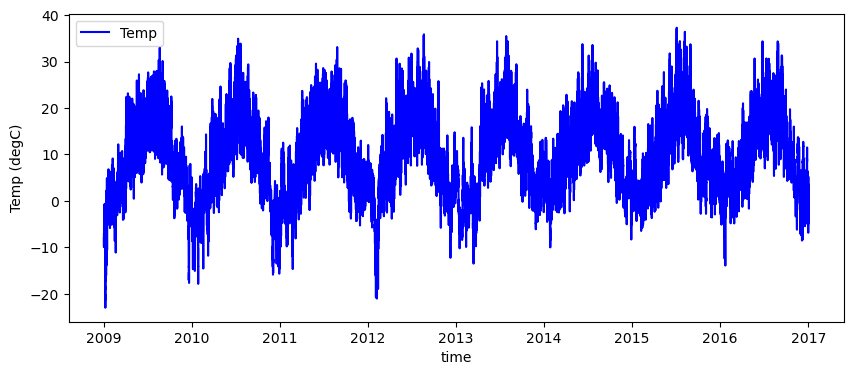

In [7]:
plt.figure(figsize=[10,4])
plt.plot(df2, color='blue',label='Temp')

plt.legend()

plt.xlabel('time')
plt.ylabel('Temp (degC)')
plt.show()

In [31]:
420551/8

52568.875

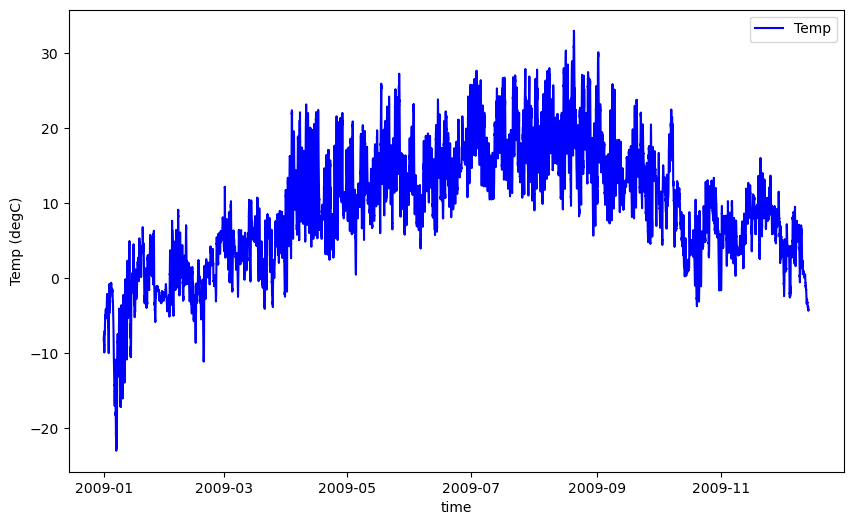

In [38]:
# one year-period tepmrature change
plt.figure(figsize=[10,6])
plt.plot(df2[0:50000], color='blue',label='Temp')

plt.legend()

plt.xlabel('time')
plt.ylabel('Temp (degC)')
plt.show()

In [8]:
#Split data into train and test
train_size = int(len(df2) * 0.70) 
validation_size=int(len(df2) * 0.90)
x_train, x_validation, x_test = df2[0:train_size], df2[train_size:validation_size], df2[validation_size:]

print("Total number of samples in the train data = ", len(x_train)) 
print("Total number of samples in the train data = ", len(x_validation)) 
print("Total number of samples in the test data = ", len(x_test)) 

Total number of samples in the train data =  294385
Total number of samples in the train data =  84110
Total number of samples in the test data =  42056


In [9]:
x_train.shape, x_validation.shape,x_test.shape

((294385, 1), (84110, 1), (42056, 1))

In [10]:
##scale or normalize data as the data is too skewed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train) 

xtrain_scaled = scaler.transform(x_train)
xvalidation_scaled = scaler.transform(x_validation)
xtest_scaled = scaler.transform(x_test)

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator


seq_size = 5  ## number of steps (lookback)


train_generator = TimeseriesGenerator(xtrain_scaled.reshape(-1), xtrain_scaled.reshape(-1), length = seq_size, batch_size=1)
print("Total number of samples in the train data = ", len(train_generator)) # 264 with seq_size=7

#Check data shape from generator
#x,y = train_generator[10]  #Check train_generator # omade satre 10 ro print karde
# print(x,y)

validation_generator = TimeseriesGenerator(xvalidation_scaled.reshape(-1), xvalidation_scaled.reshape(-1), length = seq_size, batch_size=1)
print("Total number of samples in the validation data = ", len(validation_generator)) # 264 with seq_size=7

#Also generate test data
test_generator = TimeseriesGenerator(xtest_scaled.reshape(-1), xtest_scaled.reshape(-1), length=seq_size, batch_size=1)
print("Total number of samples in the test data = ", len(test_generator)) 

Total number of samples in the train data =  294380
Total number of samples in the validation data =  84105
Total number of samples in the test data =  42051


In [12]:
x,y = train_generator[1]
print(x,y)
print(x.shape,y.shape)

[[0.24800408 0.2463054  0.24970272 0.25038218 0.25411922]] [0.26142347]
(1, 5) (1,)


In [13]:
#Define Model 
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=False, input_shape=(seq_size,1))) #in return_sequences=False ro havaset bashe, age yedone lstm dari false va age 2 ta true bashe, yek saat dashtam sare in debug mikardam
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics='mse')


Epoch 1/5
100/100 [==============================] - 470s 5s/step - loss: 0.0012 - mse: 0.0012 - val_loss: 4.8881e-04 - val_mse: 4.8881e-04
Epoch 2/5
100/100 [==============================] - 476s 5s/step - loss: 6.8356e-04 - mse: 6.8356e-04 - val_loss: 3.9877e-04 - val_mse: 3.9877e-04
Epoch 3/5
100/100 [==============================] - 512s 5s/step - loss: 4.2341e-04 - mse: 4.2341e-04 - val_loss: 5.3484e-04 - val_mse: 5.3484e-04
Epoch 4/5
100/100 [==============================] - 539s 5s/step - loss: 6.6250e-04 - mse: 6.6250e-04 - val_loss: 3.8275e-04 - val_mse: 3.8275e-04
Epoch 5/5
100/100 [==============================] - 465s 5s/step - loss: 7.5337e-04 - mse: 7.5337e-04 - val_loss: 4.2677e-04 - val_mse: 4.2677e-04


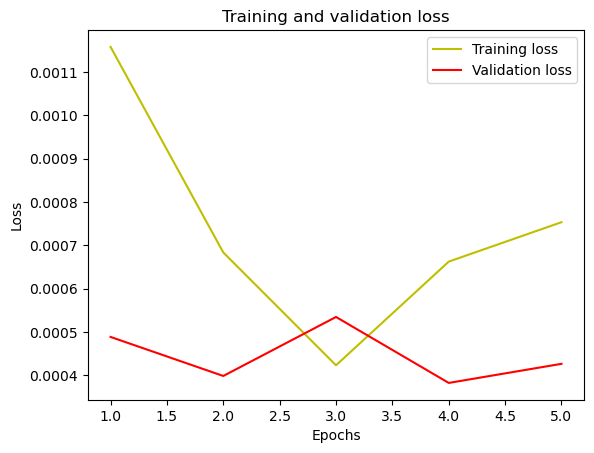

In [15]:
model_history = model.fit(train_generator, validation_data=validation_generator, epochs=5, steps_per_epoch=100)

#plot the training and validation accuracy and loss at each epoch
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [16]:
ytrainPred=model.predict(train_generator)
yvalidationPred=model.predict(validation_generator)
ytestPred=model.predict(test_generator)


42051/42051 [==============================] - 259s 6ms/step


In [17]:
ytrain_back_to_unscaled = scaler.inverse_transform(xtrain_scaled)
yvalidation_back_to_unscaled  = scaler.inverse_transform(xvalidation_scaled)
ytest_back_to_unscaled  = scaler.inverse_transform(xtest_scaled)

ytrainPred_back_to_unscaled = scaler.inverse_transform(ytrainPred)
yvalidationPred_back_to_unscaled  = scaler.inverse_transform(yvalidationPred)
ytestPred_back_to_unscaled  = scaler.inverse_transform(ytestPred)

In [18]:
x_train, x_validation, x_test = df2[0:train_size], df2[train_size:validation_size], df2[validation_size:]

In [19]:
x_train.shape, ytrain_back_to_unscaled.shape

((294385, 1), (294385, 1))

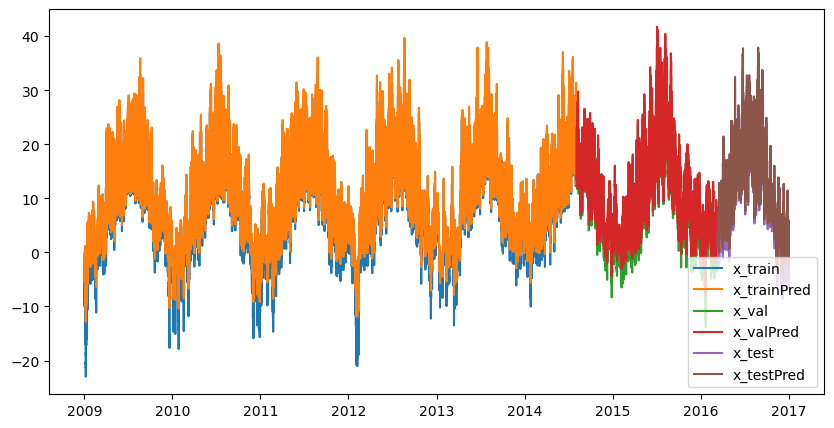

In [44]:
#x_train['ytrain_back_to_unscaled']=ytrain_back_to_unscaled

x_train['ytrainPred_back_to_unscaled']=np.nan
x_train['ytrainPred_back_to_unscaled'][seq_size:]=ytrainPred_back_to_unscaled.reshape(-1)


x_validation['yvalidationPred_back_to_unscaled']=np.nan
x_validation['yvalidationPred_back_to_unscaled'][seq_size:]=yvalidationPred_back_to_unscaled.reshape(-1)


x_test['ytestPred_back_to_unscaled']=np.nan
x_test['ytestPred_back_to_unscaled'][seq_size:]=ytestPred_back_to_unscaled.reshape(-1)
                                                

plt.figure(figsize=(10,5))
plt.plot(x_train,label=['x_train','x_trainPred'])
plt.plot(x_validation,label=['x_val','x_valPred'])
plt.plot(x_test,label=['x_test','x_testPred'])
plt.legend()

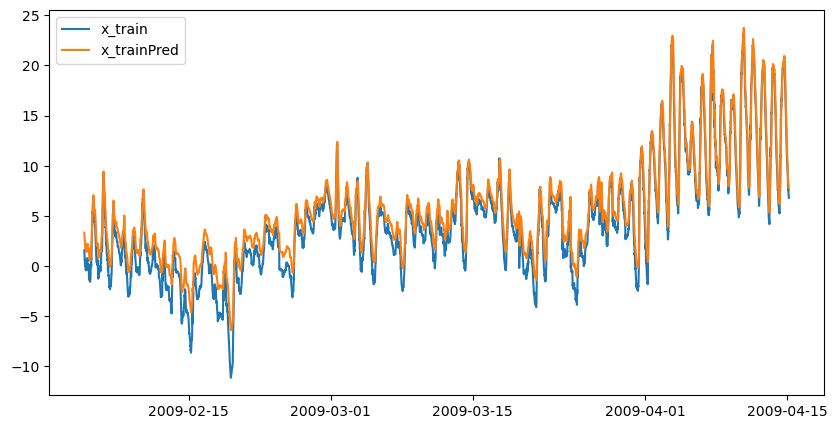

In [48]:
#x_train plot
plt.figure(figsize=(10,5))
plt.plot(x_train[5000:15000],label=['x_train','x_trainPred'])

plt.legend()
plt.show()

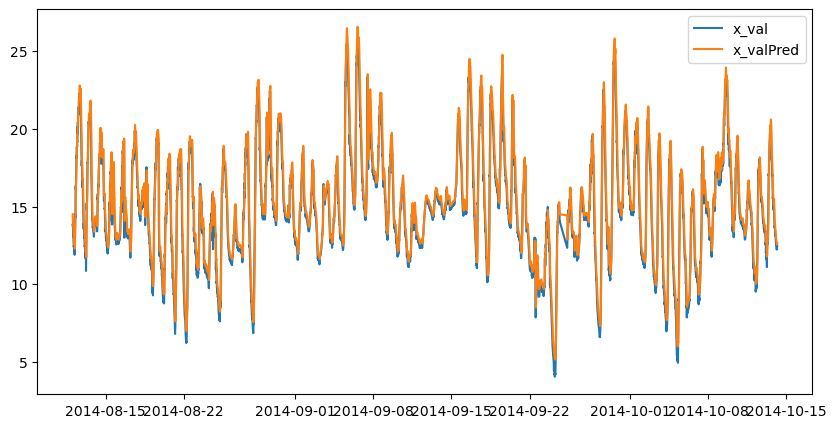

In [46]:
#x_validation plot
plt.figure(figsize=(10,5))

plt.plot(x_validation[1000:10000],label=['x_val','x_valPred'])

plt.legend()
plt.show()

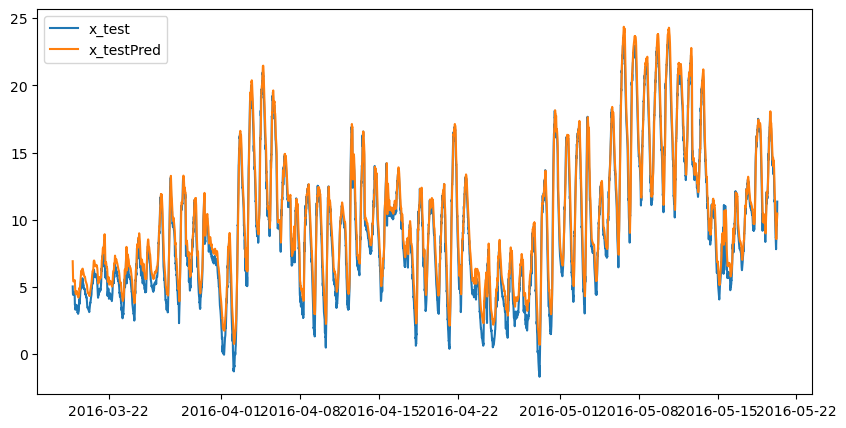

In [45]:
#x_test plot
plt.figure(figsize=(10,5))

plt.plot(x_test[1000:10000],label=['x_test','x_testPred'])
plt.legend()
plt.show()